In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import platform
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# 1. 폰트 파일 경로 설정
font_path = r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\5_fonts\Pretendard-Medium.otf"

# 2. 폰트 이름 가져오기
font_name = fm.FontProperties(fname = font_path).get_name()
fm.fontManager.addfont(font_path)

# 3. Matplotlib의 기본 폰트로 설정
plt.rc("font", family = font_name)

# 4. 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print(f"설정된 폰트 이름: {font_name}")

설정된 폰트 이름: Pretendard


In [10]:
df = pd.read_csv(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\1_data\processed\df_final_v2.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

학습 시퀀스: (8567, 24, 19) / 테스트 시퀀스: (8760, 24, 19)
device: cpu
Epoch 01/30 | Loss: 0.045029
Epoch 02/30 | Loss: 0.010488
Epoch 03/30 | Loss: 0.006146
Epoch 04/30 | Loss: 0.005166
Epoch 05/30 | Loss: 0.004547
Epoch 06/30 | Loss: 0.004339
Epoch 07/30 | Loss: 0.004202
Epoch 08/30 | Loss: 0.004267
Epoch 09/30 | Loss: 0.004333
Epoch 10/30 | Loss: 0.004410
Epoch 11/30 | Loss: 0.004560
Epoch 12/30 | Loss: 0.005096
Early stopping at epoch 12

LSTM | R²: 0.5858 | RMSE: 969.7 | MAPE: 15.35%


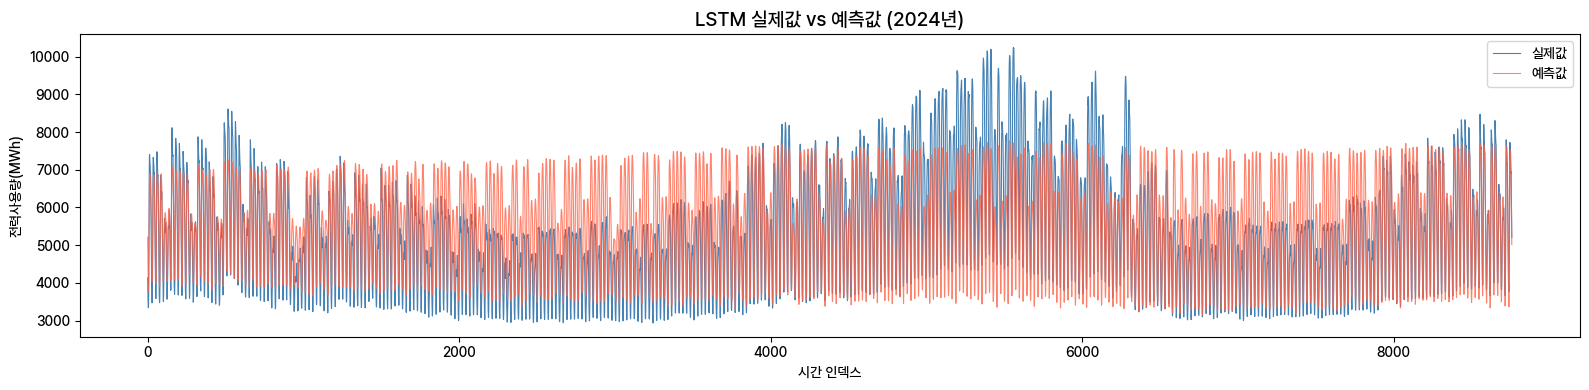

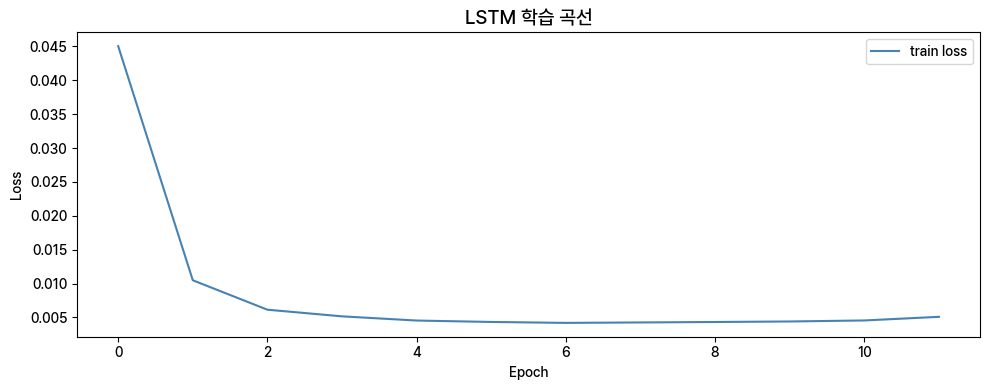

In [5]:
FEATURES_LSTM = [
    "기온(°C)", "강수량(mm)", "풍속(m/s)", "습도(%)", "일사(MJ/m2)", "전운량(10분위)",
    "미세먼지(PM10)", "초미세먼지(PM25)",
    "hour", "dayofweek", "month", "is_weekend", "is_holiday", "is_off",
    "CDD", "HDD", "체감온도", "불쾌지수", "태양광추정"
]
TARGET = "전력사용량(MWh)"

df["강수량(mm)"] = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

# ── 학습/테스트 분리 ────────────────────────────
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES_LSTM].values
y_train = train[TARGET].values
X_test  = test[FEATURES_LSTM].values
y_test  = test[TARGET].values

# ── 스케일링 ────────────────────────────────────
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_sc = scaler_X.fit_transform(X_train)
X_test_sc  = scaler_X.transform(X_test)
y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_sc  = scaler_y.transform(y_test.reshape(-1, 1))

# ── 시퀀스 생성 (24시간 윈도우) ─────────────────
SEQ_LEN = 24

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_tr, y_tr = make_sequences(X_train_sc, y_train_sc, SEQ_LEN)
X_te, y_te = make_sequences(X_test_sc,  y_test_sc,  SEQ_LEN)

print(f"학습 시퀀스: {X_tr.shape} / 테스트 시퀀스: {X_te.shape}")

# ── Tensor 변환 ──────────────────────────────────
X_tr_t = torch.FloatTensor(X_tr)
y_tr_t = torch.FloatTensor(y_tr)
X_te_t = torch.FloatTensor(X_te)
y_te_t = torch.FloatTensor(y_te)

train_ds     = TensorDataset(X_tr_t, y_tr_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)

# ── LSTM 모델 정의 ───────────────────────────────
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # 마지막 시점만 사용

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

model = LSTMModel(input_size=len(FEATURES_LSTM)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ── 학습 ────────────────────────────────────────
EPOCHS    = 30
best_loss = float("inf")
patience  = 5
counter   = 0
history   = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    history.append(avg_loss)
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {avg_loss:.6f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\6_models\best_lstm.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ── 예측 ────────────────────────────────────────
model.load_state_dict(torch.load(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\6_models\best_lstm.pt"))
model.eval()
with torch.no_grad():
    pred_sc = model(X_te_t.to(device)).cpu().numpy()

pred   = scaler_y.inverse_transform(pred_sc).flatten()
actual = scaler_y.inverse_transform(y_te).flatten()

r2   = round(r2_score(actual, pred), 4)
rmse = round(np.sqrt(mean_squared_error(actual, pred)), 1)
mape = round(mean_absolute_percentage_error(actual, pred) * 100, 2)

print(f"\nLSTM | R²: {r2} | RMSE: {rmse} | MAPE: {mape}%")

# ── 실제값 vs 예측값 시각화 ─────────────────────
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(actual, label="실제값", color="steelblue", linewidth=0.8)
ax.plot(pred,   label="예측값", color="tomato",    linewidth=0.8, alpha=0.8)
ax.set_title("LSTM 실제값 vs 예측값 (2024년)", fontsize=14)
ax.set_xlabel("시간 인덱스")
ax.set_ylabel("전력사용량(MWh)")
ax.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\LSTM_실제vs예측.png", dpi=300)
plt.show()

# ── 학습 곡선 ───────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history, label="train loss", color="steelblue")
ax.set_title("LSTM 학습 곡선", fontsize=14)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\LSTM_학습곡선.png", dpi=300)
plt.show()

Epoch 01/80 | Loss: 0.014648
Epoch 02/80 | Loss: 0.006025
Epoch 03/80 | Loss: 0.006061
Epoch 04/80 | Loss: 0.006306
Epoch 05/80 | Loss: 0.006385
Epoch 06/80 | Loss: 0.006377
Epoch 07/80 | Loss: 0.005723
Epoch 08/80 | Loss: 0.005374
Epoch 09/80 | Loss: 0.005368
Epoch 10/80 | Loss: 0.005692
Epoch 11/80 | Loss: 0.005989
Epoch 12/80 | Loss: 0.005787
Epoch 13/80 | Loss: 0.005952
Epoch 14/80 | Loss: 0.006959
Epoch 15/80 | Loss: 0.006606
Epoch 16/80 | Loss: 0.007317
Early stopping at epoch 16

Improved LSTM | R²: 0.6062 | RMSE: 947.9 | MAPE: 15.33%


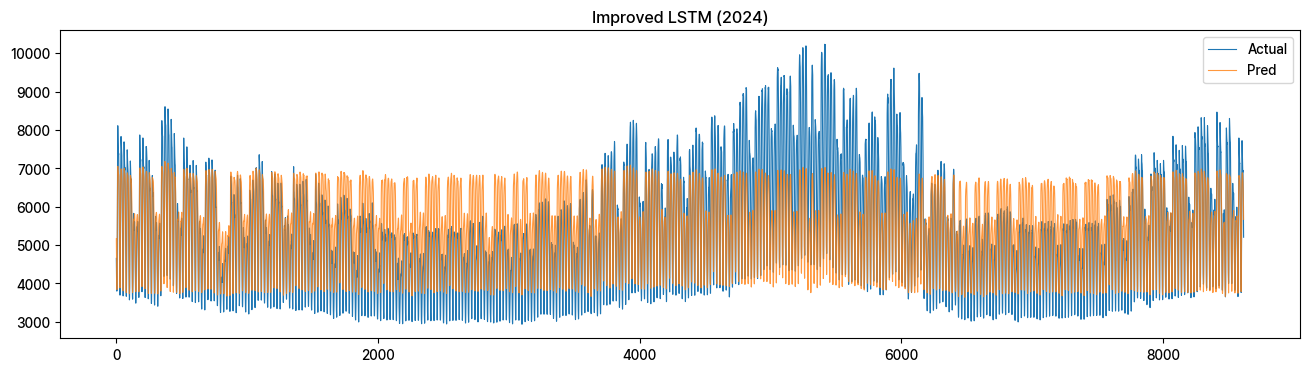

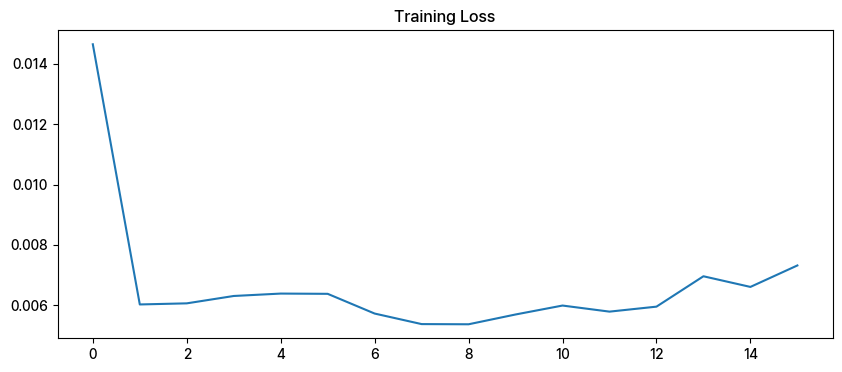

In [11]:
# ─────────────────────────────────────────────
# 1️⃣ Cyclical Encoding
# ─────────────────────────────────────────────
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

df["dow_sin"] = np.sin(2*np.pi*df["dayofweek"]/7)
df["dow_cos"] = np.cos(2*np.pi*df["dayofweek"]/7)

# 기존 hour, month, dayofweek 제거
df = df.drop(columns=["hour", "month", "dayofweek"])

# ─────────────────────────────────────────────
# 2️⃣ Feature 정의
# ─────────────────────────────────────────────
FEATURES_LSTM = [
    "기온(°C)", "강수량(mm)", "풍속(m/s)", "습도(%)",
    "일사(MJ/m2)", "전운량(10분위)",
    "미세먼지(PM10)", "초미세먼지(PM25)",
    "is_weekend", "is_holiday", "is_off",
    "CDD", "HDD", "체감온도", "불쾌지수", "태양광추정",
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
    "dow_sin", "dow_cos"
]

TARGET = "전력사용량(MWh)"

df["강수량(mm)"] = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

# ─────────────────────────────────────────────
# 3️⃣ Train / Test 분리
# ─────────────────────────────────────────────
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES_LSTM].values
y_train = train[TARGET].values
X_test  = test[FEATURES_LSTM].values
y_test  = test[TARGET].values

# ─────────────────────────────────────────────
# 4️⃣ Scaling
# ─────────────────────────────────────────────
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_sc = scaler_X.fit_transform(X_train)
X_test_sc  = scaler_X.transform(X_test)

y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_sc  = scaler_y.transform(y_test.reshape(-1, 1))

# ─────────────────────────────────────────────
# 5️⃣ Sequence 생성 (168시간)
# ─────────────────────────────────────────────
SEQ_LEN = 168

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_tr, y_tr = make_sequences(X_train_sc, y_train_sc, SEQ_LEN)
X_te, y_te = make_sequences(X_test_sc,  y_test_sc,  SEQ_LEN)

# Tensor 변환
X_tr_t = torch.FloatTensor(X_tr)
y_tr_t = torch.FloatTensor(y_tr)
X_te_t = torch.FloatTensor(X_te)
y_te_t = torch.FloatTensor(y_te)

train_ds = TensorDataset(X_tr_t, y_tr_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)

# ─────────────────────────────────────────────
# 6️⃣ LSTM 모델 정의
# ─────────────────────────────────────────────
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=len(FEATURES_LSTM)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ─────────────────────────────────────────────
# 7️⃣ 학습
# ─────────────────────────────────────────────
EPOCHS = 80
best_loss = float("inf")
patience = 7
counter = 0
history = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    history.append(avg_loss)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {avg_loss:.6f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\6_models\best_lstm_improved.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ─────────────────────────────────────────────
# 8️⃣ 예측
# ─────────────────────────────────────────────
model.load_state_dict(torch.load(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\6_models\best_lstm_improved.pt"))
model.eval()

with torch.no_grad():
    pred_sc = model(X_te_t.to(device)).cpu().numpy()

pred   = scaler_y.inverse_transform(pred_sc).flatten()
actual = scaler_y.inverse_transform(y_te).flatten()

r2   = round(r2_score(actual, pred), 4)
rmse = round(np.sqrt(mean_squared_error(actual, pred)), 1)
mape = round(mean_absolute_percentage_error(actual, pred) * 100, 2)

print(f"\nImproved LSTM | R²: {r2} | RMSE: {rmse} | MAPE: {mape}%")

# ─────────────────────────────────────────────
# 9️⃣ 시각화
# ─────────────────────────────────────────────
plt.figure(figsize=(16,4))
plt.plot(actual, label="Actual", linewidth=0.8)
plt.plot(pred, label="Pred", linewidth=0.8, alpha=0.8)
plt.title("Improved LSTM (2024)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history)
plt.title("Training Loss")
plt.show()